In [125]:
import pandas as pd
import numpy as np
import math
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

In [126]:
#FUNCION PARA COMPARAR DENSIDAD DE DISTRIBUCIONES ANTES Y DESPUES DE IMPUTAR
def comparison_dist(data_1:pd.Series, data_2:pd.Series, action:str, x_label:str, fig_size:tuple):
    plt.style.use("bmh")    
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=fig_size)

    #GRAFICO 1
    sns.kdeplot(x=data_1, ax=ax[0])
    ax[0].set_title('Distribucion original')
    ax[0].set_xlabel(x_label)

    #GRAFICO 2
    sns.kdeplot(data=data_2, ax=ax[1])
    ax[1].set_xlabel(x_label)
    ax[1].set_title(f'Distribucion despues de {action}') #ACTION(IMPUTAR, ELIMINAR)

    #PLOTEO
    plt.tight_layout()
    plt.show()
    plt.style.use("default")

In [127]:
#FUNCION PARA IMPRIMIR INFORMACION DE LA VARIABLE
def get_data_info(var:pd.Series):
    #MEDIDAS DE TENDENCIA CENTRAL DE LA VARIABLE
    print('Medidas de tendencia central')
    print(f'\tMedia: {var.mean().round(2)}')
    print(f'\tMediana: {var.median()}')
    print(f'\tModa: {stats.mode(var)[0]}')

    #MEDIDAS DE DISPERSION
    print('\nMedidas de dispersion')
    print(f'\tCoef asimetria: {var.skew().round(2)}')
    print(f'\tKurtosis: {var.kurtosis().round(2)}')

    #RANGO INTERCUARTILICO
    q1 = var.quantile(0.25)
    q3 = var.quantile(0.75)
    irq = q3-q1

    #VALORES ATIPICOS
    print('\nValores atipicos')

    #MINIMO NO ATIPICO
    min = q1-(irq*1.5)
    print(f'\tMinimo no atipico: {min.round(2)}')

    #MAXIMO NO ATIPICO
    max = q3+(irq*1.5)
    print(f'\tMaximo no atipico: {max}')

    #CONTEO DE ATIPICOS
    outliers = var.loc[(var >max)|(var<min)].shape[0]
    print(f'\nCantidad de valores outliers: {outliers}')

In [128]:
#FUNCION PARA GRAFICAR BOXPLOT FINES DETECION DE OUTLIERS
def plot_outliers(var:pd.Series, var_name:str, x_label):
    plt.figure(figsize=(8,3))
    mpl.style.use('bmh')
    sns.boxplot(x=var)
    plt.title(f'Distribucion de la variable {var_name}')
    plt.xlabel(x_label)
    plt.ylabel('Variable')
    plt.tight_layout()
    plt.show()
    mpl.style.use('default')

In [129]:
df = pd.read_csv('data_reg.csv')
df.head(3)

,Booking_ID,num_adults,num_children,weekend_nights,week_nights,total_nights,meal_plan,car_parking,room_type,lead_time,...,num_prev_cancellations,num_prev_not_canceled,avg_price_room,num_sp_requests,booking_status,meal_plan_cod,room_type_cod,mkt_segment_cod,arrival_season_cod,booking_status_cod
0,INN00001,2,0,1,2,3,Meal Plan 1,0,Room_Type 1,224,...,0,0,65.00,0,No cancelada,1,1,3,3,0
1,INN00002,2,0,2,3,5,Not Selected,0,Room_Type 1,5,...,0,0,106.68,1,No cancelada,0,1,4,1,0
2,INN00003,1,0,2,1,3,Meal Plan 1,0,Room_Type 1,1,...,0,0,60.00,0,Cancelada,1,1,4,1,1


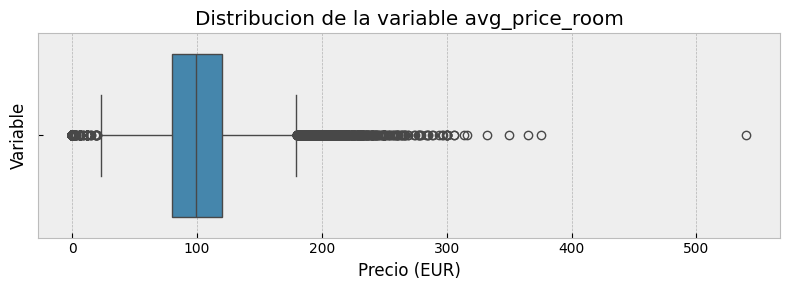

In [130]:
#BOXPLOT PARA IDENTIFICAR OUTLIERS
plot_outliers(df.avg_price_room, 'avg_price_room', 'Precio (EUR)')

In [131]:
#DETECCION DE OUTLIERS
from sklearn.covariance import EllipticEnvelope

cov_det = EllipticEnvelope(contamination=0.05)
outlier_pred = cov_det.fit_predict(df.avg_price_room.values.reshape(-1,1))
outlier_pred = pd.Series(outlier_pred.flatten(), name='is_outlier')

outlier_pred = pd.concat([df.avg_price_room, outlier_pred], axis=1).reset_index()
outlier_pred.is_outlier.value_counts()

is_outlier
 1    34349
-1     1784
Name: count, dtype: int64

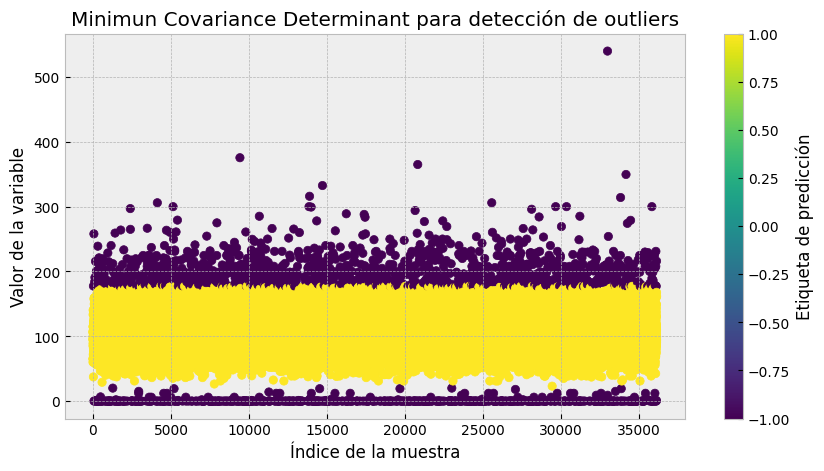

In [132]:
#REPRESENTACION GRAFICA DE OUTLIERS
mpl.style.use('bmh')
plt.figure(figsize=(10,5))
plt.scatter(outlier_pred.index, outlier_pred.avg_price_room, c=outlier_pred.is_outlier, cmap='viridis')
plt.xlabel('Índice de la muestra')
plt.ylabel('Valor de la variable')
plt.title('Minimun Covariance Determinant para detección de outliers')
plt.colorbar(label='Etiqueta de predicción')
plt.show()
mpl.style.use('bmh')

In [133]:
#SE CREA DATASET PARA SEPARAR OUTLIERS Y NO OUTLIERS 
_df = pd.concat([df, outlier_pred.is_outlier], axis=1).reset_index()

In [134]:
_df.loc[: ,'total_guests'] = _df.apply(lambda x: x.num_adults + x.num_children, axis=1)

In [135]:
var_dummy = pd.get_dummies(_df[['mkt_segment','room_type']], dtype=int)

In [136]:
_df = pd.concat([ var_dummy,
                  _df[['booking_status_cod','lead_time','total_guests', 'arrival_year', 'num_sp_requests', 'is_outlier','avg_price_room']]
                ], axis=1)

y = _df.loc[_df.is_outlier == 1, 'avg_price_room']

vars = list(_df.columns)[:-2]

x = _df.loc[_df.is_outlier == 1, vars]
x_outlier = _df.loc[_df.is_outlier == -1, vars]

In [137]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [138]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

model = RandomForestRegressor(max_depth=12, max_features=0.5, n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [139]:
#METRICAS DE REGRESION
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 378.4133710739239
Root Mean Squared Error (RMSE): 19.45284994734509
R^2 Score: 0.48299774576418997


In [140]:
y_pred = model.predict(x_outlier)

df['is_outlier'] = outlier_pred.is_outlier

df.loc[df.is_outlier == -1, 'avg_price_room'] = y_pred

df.drop(columns='is_outlier', inplace=True)

In [141]:
#df.to_csv('test.csv')